# Kickstarter Project Analysis

This notebook analyzes Kickstarter project data to predict the success of projects based on various features. We will explore the data, clean it, create new features, and build machine learning models to predict project outcomes.

## 1. Importing Libraries

We begin by importing the necessary libraries for data manipulation, visualization, and modeling.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

# Set visualization theme
sns.set_theme(rc={'figure.figsize': (20, 6)})


## 2. Exploratory Data Analysis (EDA)

In this section, we perform an exploratory data analysis to understand the distribution and relationships in the data. We will explore categorical distributions, identify outliers, and investigate potential duplicates and discrepancies in the dataset.

### 2.1 Initial Data Exploration


In [2]:
# Load data
kickstarter_data = pd.read_csv('data/kickstarter_projects.csv')

# Display basic information about the dataset
print(kickstarter_data.info())
print(kickstarter_data.describe())

# Display the first and last few rows of the dataset
print(kickstarter_data.head(10))
print(kickstarter_data.tail(10))

# Checking for missing values
print(kickstarter_data.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB
None
                 ID          Goal       Pledged        Backers
count  3.748530e+05  3.748530e+05  3.748530e+05  374853.000000
mean   1.074656e+09  4.586378e+04  9.121073e+03     106.690359
std    6.191377e+08  1.158778e+06  9.132054e+04     911.718520
min    5.971000e+03  0.000000e+00  

### 2.2 Analyzing Categorical Variables

We'll analyze the distribution of categorical variables such as `Category`, `Subcategory`, and `Country` to understand the composition of the dataset.


State
Failed        197611
Successful    133851
Canceled       38751
Live            2798
Suspended       1842
Name: count, dtype: int64
Category
Film & Video    62694
Music           49529
Publishing      39378
Games           35225
Technology      32562
Design          30065
Art             28151
Food            24599
Fashion         22812
Theater         10911
Name: count, dtype: int64
Subcategory
Product Design    22310
Documentary       16138
Tabletop Games    14178
Music             13339
Shorts            12357
Video Games       11828
Food              11492
Film & Video       9222
Fiction            9168
Fashion            8554
Name: count, dtype: int64


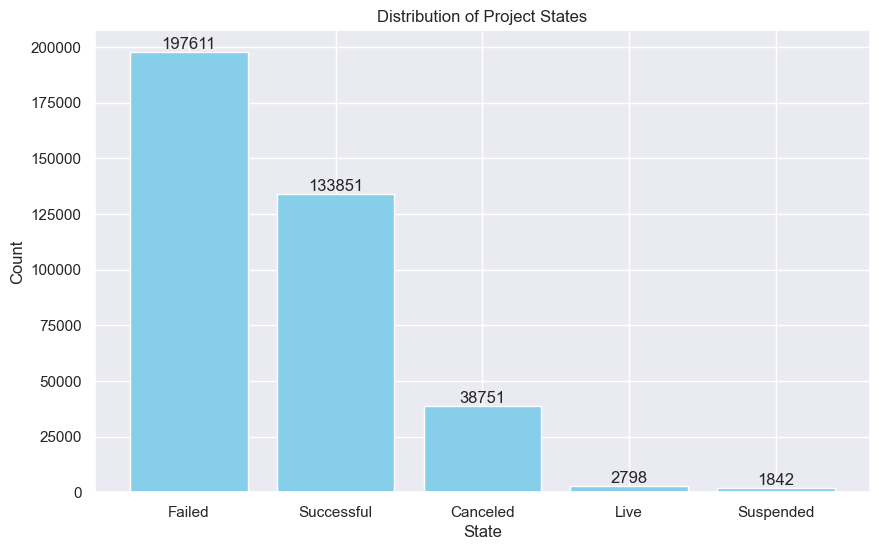

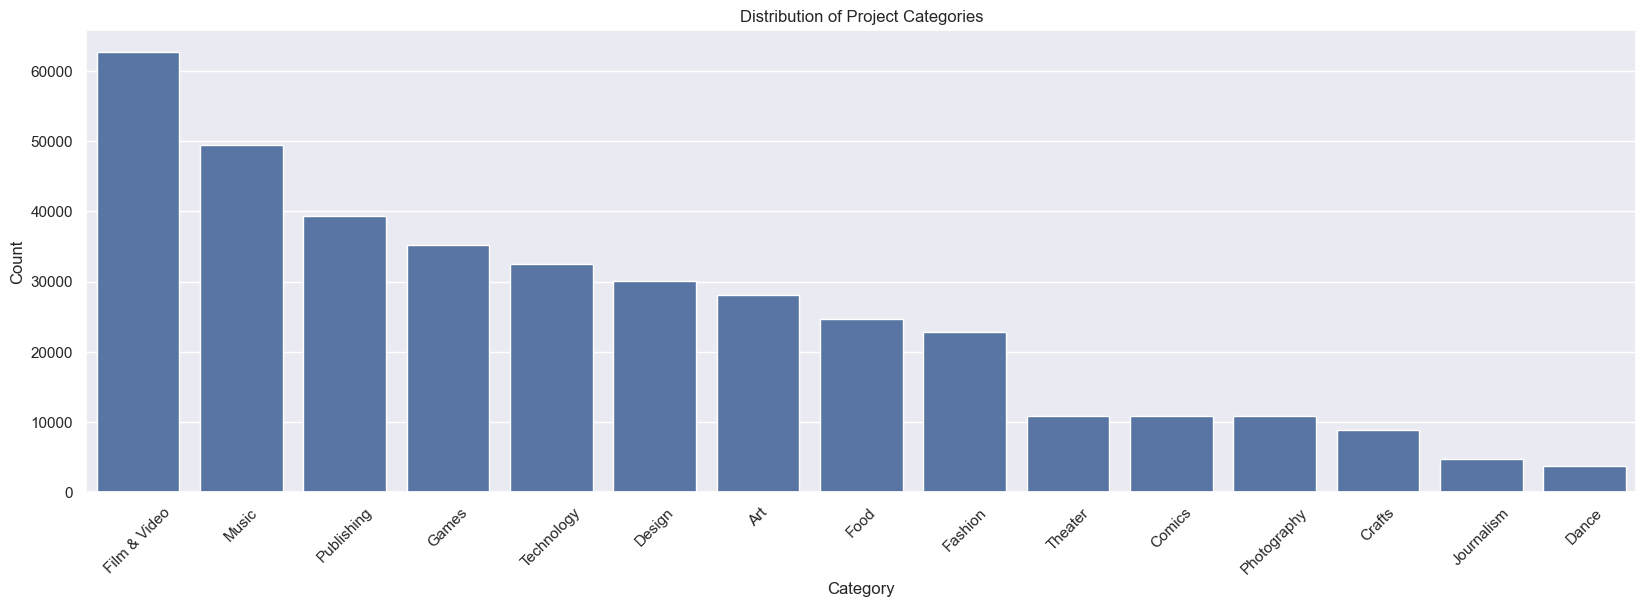

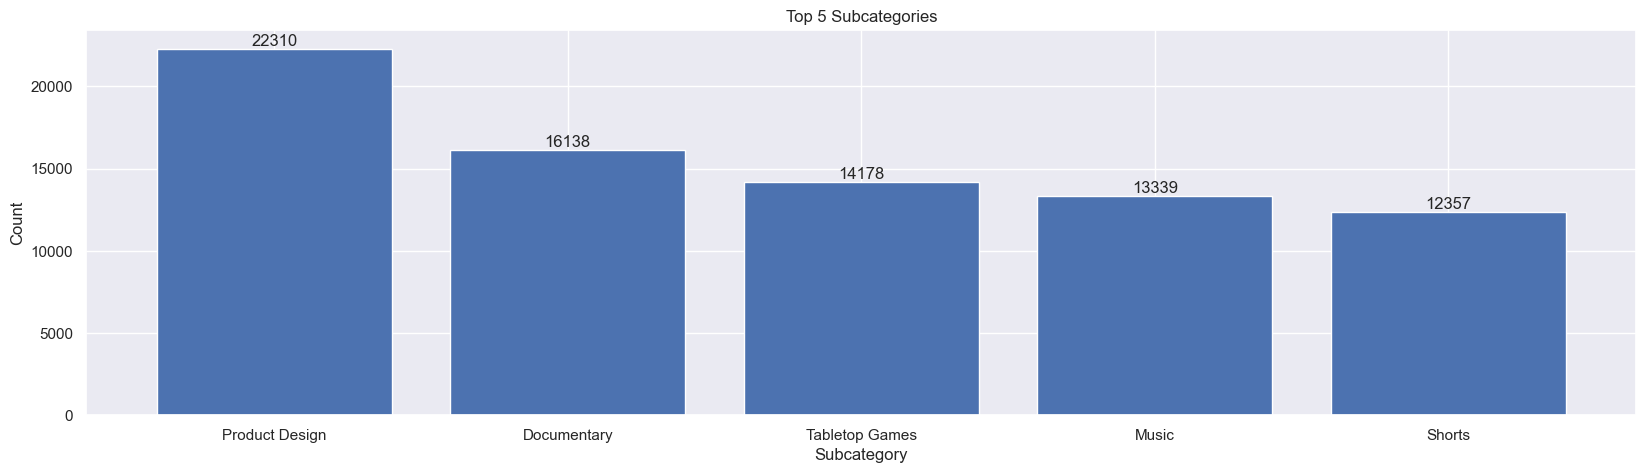

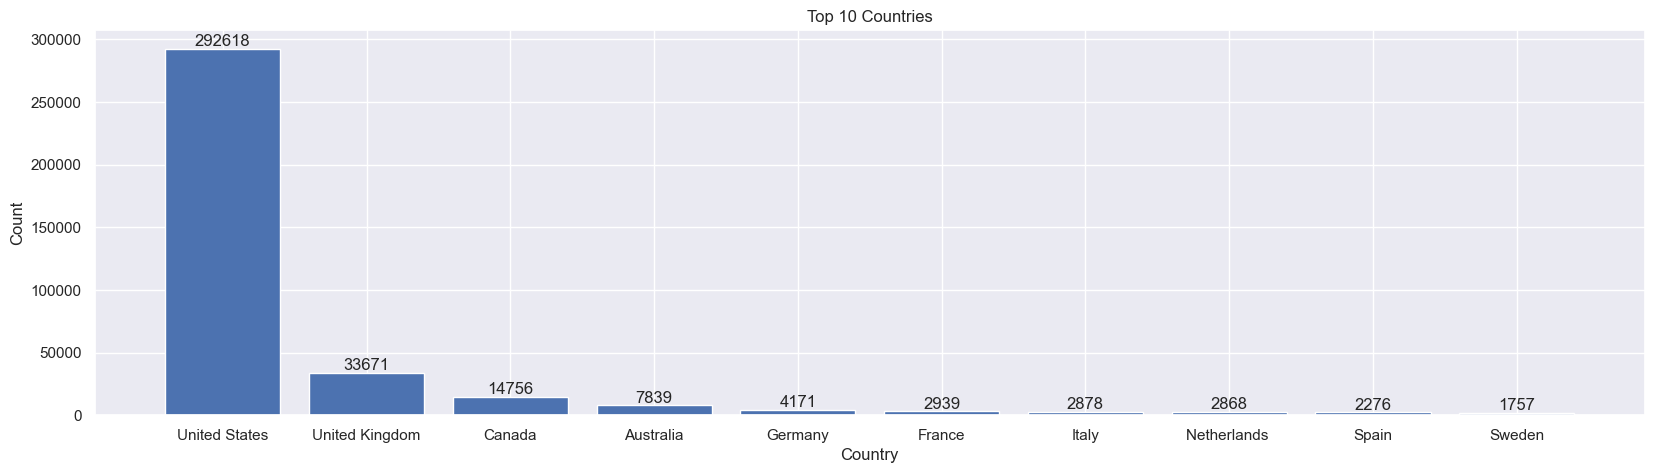

In [3]:
# Analyzing the distribution of 'State', 'Category', 'Subcategory', and 'Country'
print(kickstarter_data['State'].value_counts())
print(kickstarter_data['Category'].value_counts().nlargest(10))
print(kickstarter_data['Subcategory'].value_counts().nlargest(10))

# Visualizing the distribution of 'State'
state_counts = kickstarter_data['State'].value_counts()
plt.figure(figsize=(10, 6))
bars = plt.bar(state_counts.index, state_counts.values, color='skyblue')
plt.ylabel('Count')
plt.xlabel('State')
plt.title('Distribution of Project States')
plt.bar_label(bars)
plt.show()

# Visualizing the distribution of the top categories
plt.figure(figsize=(20, 6))
sns.countplot(data=kickstarter_data, x='Category', order=kickstarter_data['Category'].value_counts().index)
plt.title('Distribution of Project Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Visualizing the distribution of the top 5 subcategories
subcategory_count = kickstarter_data['Subcategory'].value_counts().nlargest(5)
plt.figure(figsize=(20, 5))
bars = plt.bar(subcategory_count.index, subcategory_count.values)
plt.ylabel('Count')
plt.xlabel('Subcategory')
plt.title('Top 5 Subcategories')
plt.bar_label(bars)
plt.show()

# Visualizing the distribution of the top 10 countries
country_count = kickstarter_data['Country'].value_counts().nlargest(10)
plt.figure(figsize=(20, 5))
bars = plt.bar(country_count.index, country_count.values)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Top 10 Countries')
plt.bar_label(bars)
plt.show()


### 2.3 Analyzing Numerical Variables

Next, we'll explore the distribution of numerical variables like `Goal`, `Pledged`, and `Backers`.


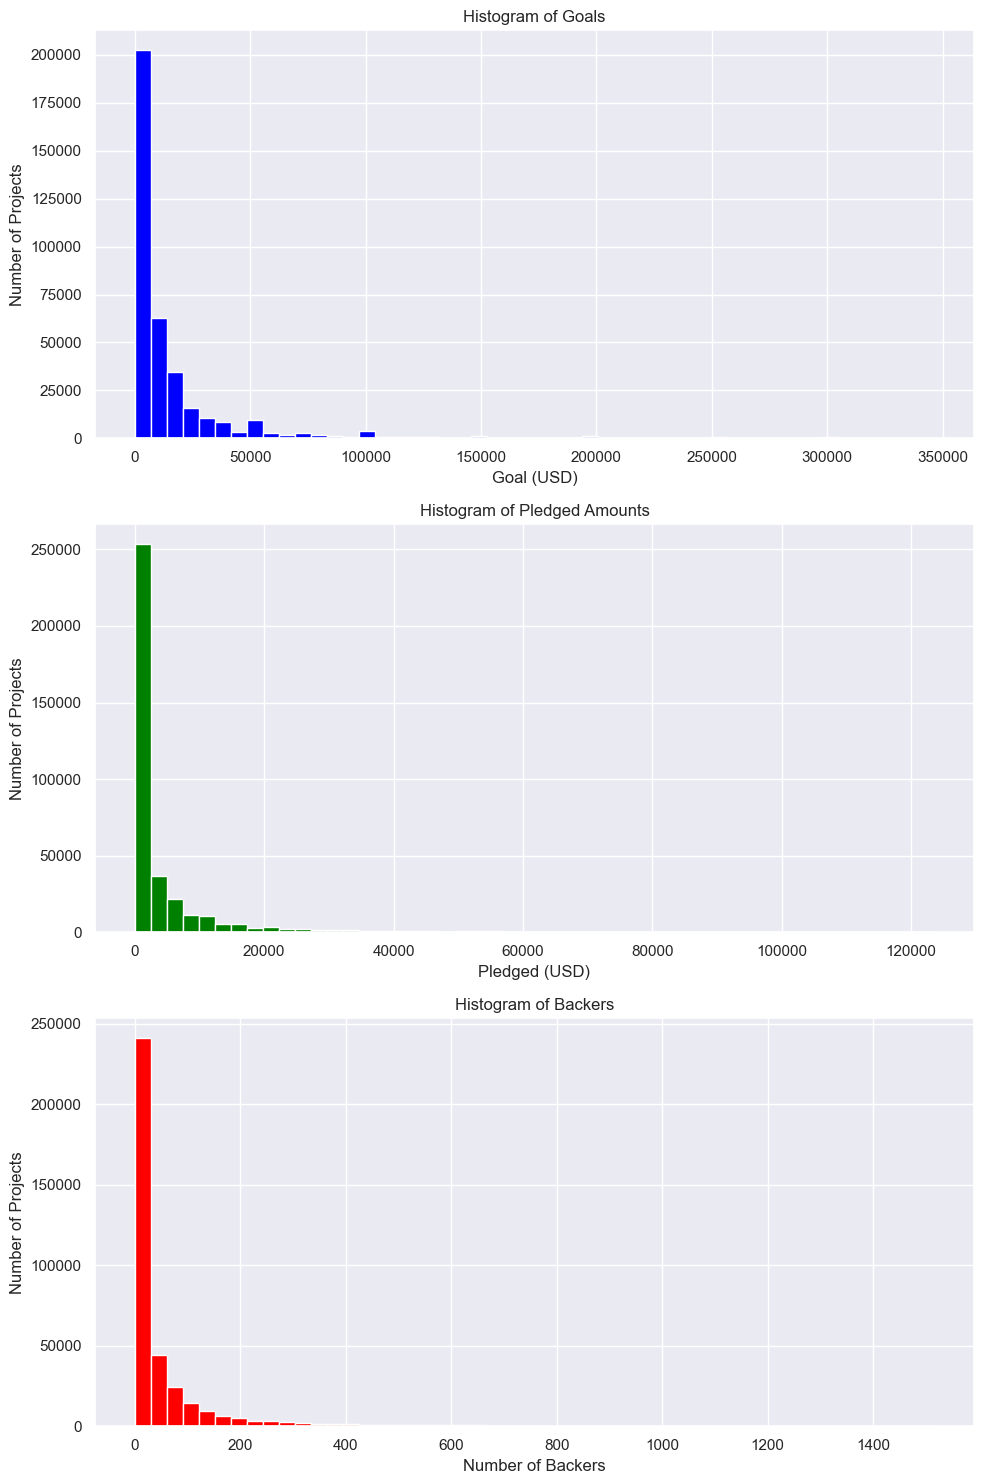

In [4]:
# Plotting histograms for numerical features: 'Goal', 'Pledged', 'Backers'
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot for 'Goal'
axes[0].hist(kickstarter_data['Goal'], bins=50, color='blue', range=[0, kickstarter_data['Goal'].quantile(0.99)])
axes[0].set_title('Histogram of Goals')
axes[0].set_xlabel('Goal (USD)')
axes[0].set_ylabel('Number of Projects')

# Plot for 'Pledged'
axes[1].hist(kickstarter_data['Pledged'], bins=50, color='green', range=[0, kickstarter_data['Pledged'].quantile(0.99)])
axes[1].set_title('Histogram of Pledged Amounts')
axes[1].set_xlabel('Pledged (USD)')
axes[1].set_ylabel('Number of Projects')

# Plot for 'Backers'
axes[2].hist(kickstarter_data['Backers'], bins=50, color='red', range=[0, kickstarter_data['Backers'].quantile(0.99)])
axes[2].set_title('Histogram of Backers')
axes[2].set_xlabel('Number of Backers')
axes[2].set_ylabel('Number of Projects')

plt.tight_layout()
plt.show()


### 2.4 Correlation Analysis

We will check for correlations between key numerical variables to understand their relationships.


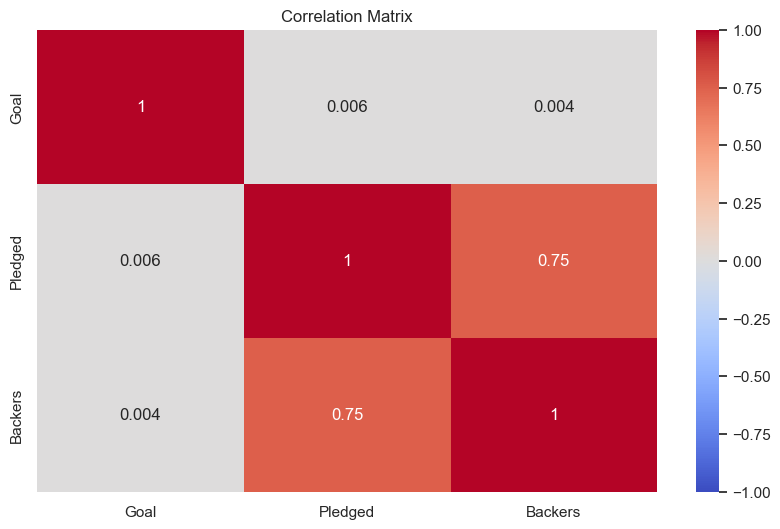

In [5]:
# Correlation matrix
correlation_matrix = kickstarter_data[['Goal', 'Pledged', 'Backers']].corr().round(3)

# Display correlation matrix with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


### 2.5 Handling Duplicates and Outliers

In this section, we investigate and handle potential duplicate projects and outliers in the numerical data.


In [6]:
# Checking for duplicate project names in the dataset
duplicate_project_names = kickstarter_data['Name'].duplicated().sum()
print(f"Number of duplicate project names: {duplicate_project_names}")

# Displaying some of the duplicate project names with their associated details
duplicate_names_sorted = kickstarter_data[kickstarter_data['Name'].duplicated(keep=False)]
duplicate_names_sorted = duplicate_names_sorted.sort_values(by='Name')[['Name', 'Category', 'Subcategory', 'Country', 'Launched', 'Deadline', 'Goal', 'Pledged', 'Backers', 'State']]
print(duplicate_names_sorted.head(10))

# Calculating outliers in numerical features using the IQR method
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    return outliers

outliers_goal = calculate_outliers(kickstarter_data['Goal'])
outliers_pledged = calculate_outliers(kickstarter_data['Pledged'])
outliers_backers = calculate_outliers(kickstarter_data['Backers'])

print(f"Outliers in Goal: {outliers_goal}, Outliers in Pledged: {outliers_pledged}, Outliers in Backers: {outliers_backers}")


Number of duplicate project names: 2792
                                                     Name      Category  \
123277  "...The Last shall be first..." LODB Lifestyle...       Fashion   
124378  "...The Last shall be first..." LODB Lifestyle...       Fashion   
28543                                     "A Fresh Start"  Film & Video   
81934                                     "A Fresh Start"  Film & Video   
232766      "American Sports Stories" - An Athletic Quest  Film & Video   
338352      "American Sports Stories" - An Athletic Quest  Film & Video   
196404                         "City of Mercy" (Canceled)  Film & Video   
159718                         "City of Mercy" (Canceled)  Film & Video   
127715  "Cut From the Illest Cloth" - The Brand New Fu...         Music   
131480  "Cut From the Illest Cloth" - The Brand New Fu...         Music   

         Subcategory         Country             Launched    Deadline    Goal  \
123277       Fashion   United States  2013-12-19 21:5

## 3. Data Preprocessing

Now, we move on to preprocessing the data for model training. This includes handling date conversions, creating new features, applying assumptions, and encoding categorical variables.

### Assumption: Using the Most Recent Campaign

For projects with multiple campaigns under the same name, we assume that the most recent campaign is the most relevant. Therefore, we retain only the most recent campaign for each project name.



In [7]:
# Convert dates and calculate project duration
kickstarter_data['Deadline'] = pd.to_datetime(kickstarter_data['Deadline'])
kickstarter_data['Launched'] = pd.to_datetime(kickstarter_data['Launched'])
kickstarter_data['duration_days'] = (kickstarter_data['Deadline'] - kickstarter_data['Launched']).dt.days

# Add name counter
kickstarter_data.loc[:, 'name_counter'] = kickstarter_data.groupby('Name')['Name'].transform('count')

# Drop rows with 'Live' state
kickstarter_data = kickstarter_data[kickstarter_data['State'] != 'Live']

# Convert project state to binary (Successful = 1, Others = 0)
kickstarter_data.loc[:, 'State'] = kickstarter_data['State'].apply(lambda x: 1 if x == 'Successful' else 0)



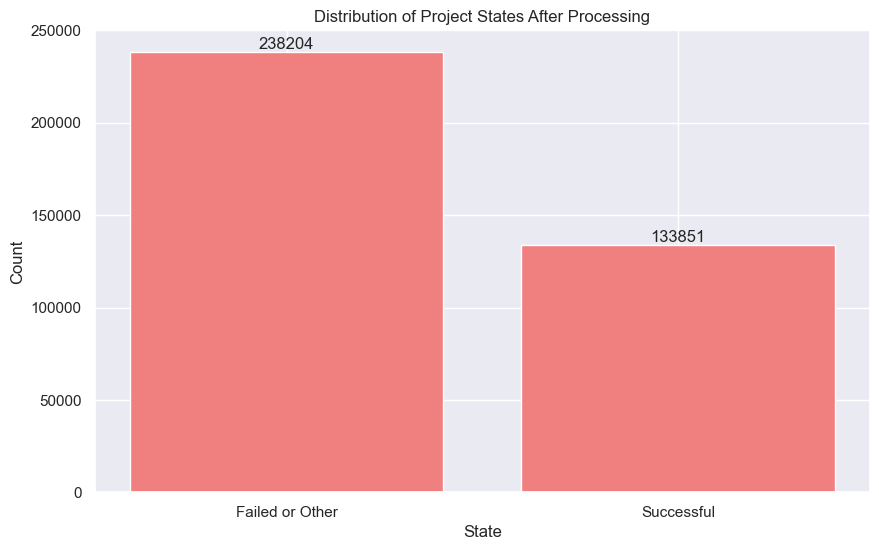

In [8]:
# Visualizing the processed 'State' column
processed_state_counts = kickstarter_data['State'].value_counts()
plt.figure(figsize=(10, 6))
bars = plt.bar(processed_state_counts.index, processed_state_counts.values, color='lightcoral')
plt.ylabel('Count')
plt.xlabel('State')
plt.title('Distribution of Project States After Processing')
plt.xticks(ticks=[0, 1], labels=['Failed or Other', 'Successful'])
plt.bar_label(bars)
plt.show()

In [9]:
# Exclude certain projects
exclude_names = ['Test (Canceled)', 'Canceled (Canceled)', 'Deleted (Canceled)']
kickstarter_data = kickstarter_data[~kickstarter_data['Name'].isin(exclude_names)]

# One-Hot Encoding for categorical variables
top_subcategories = kickstarter_data['Subcategory'].value_counts().nlargest(10).index.tolist()
top_countries = kickstarter_data['Country'].value_counts().nlargest(5).index.tolist()
kickstarter_data['Subcategory'] = kickstarter_data['Subcategory'].apply(lambda x: x if x in top_subcategories else 'Other')
kickstarter_data['Country'] = kickstarter_data['Country'].apply(lambda x: x if x in top_countries else 'Other')
kickstarter_data = pd.get_dummies(kickstarter_data, columns=['Category', 'Subcategory', 'Country'])

# Assumption 3: Take the most recent campaign
def handle_assumption(data):
    return data.sort_values(by='Launched', ascending=False).drop_duplicates(subset='Name', keep='first')

# Apply assumption and drop unnecessary columns
kickstarter_data = handle_assumption(kickstarter_data)
kickstarter_data.drop(['Name', 'ID', 'Launched', 'Deadline'], inplace=True, axis=1)


In [10]:
# Check the number of rows corresponding to success and failure
state_counts = kickstarter_data['State'].value_counts()

# Print the results
print("Number of Successful Projects:", state_counts.get(1, 0))
print("Number of Failed Projects:", state_counts.get(0, 0))

Number of Successful Projects: 133028
Number of Failed Projects: 236263


In [11]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = kickstarter_data[kickstarter_data['State'] == 0]
df_minority = kickstarter_data[kickstarter_data['State'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # match number in minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Display new class counts
print("Number of Successful Projects:", df_balanced['State'].value_counts().get(1, 0))
print("Number of Failed Projects:", df_balanced['State'].value_counts().get(0, 0))


Number of Successful Projects: 133028
Number of Failed Projects: 133028


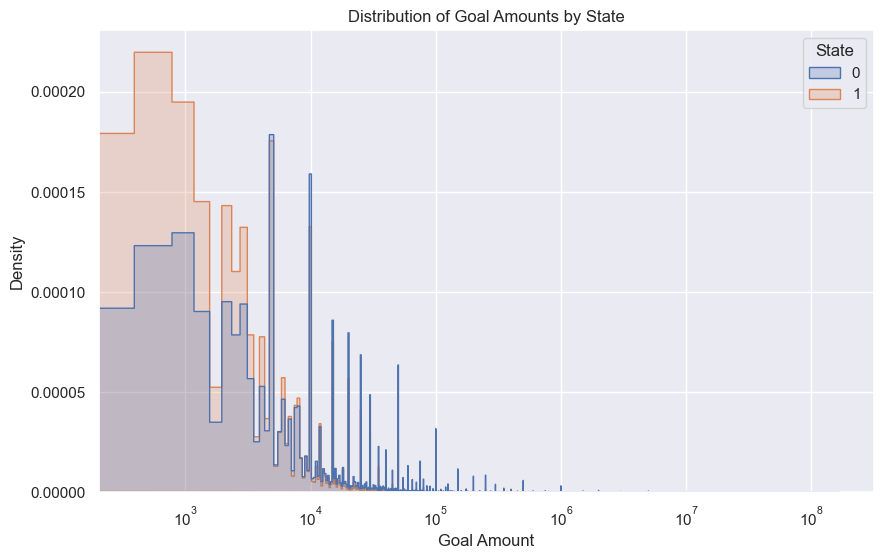

In [12]:
# Plot histogram with density plots for the Pledged amount by State
plt.figure(figsize=(10, 6))
sns.histplot(data=kickstarter_data, x='Goal', hue='State', kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution of Goal Amounts by State')
plt.xlabel('Goal Amount')
plt.ylabel('Density')
plt.xscale('log')  # Use a logarithmic scale if the data is skewed
plt.show()

## 4. Baseline Model: Logistic Regression

We begin with a simple Logistic Regression model as our baseline. This model will serve as a reference point to evaluate more complex models.


In [13]:
# Prepare data for Logistic Regression
y = df_balanced['State'].astype(int)
X = df_balanced.drop(['State', 'Pledged'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=5000)
logistic_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_logistic = logistic_model.predict(X_test_scaled)

# Validation function
def validation(y_pred, y_test):
    print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred))
    print('Accuracy Score :',accuracy_score(y_test, y_pred))
    print('Report : ')
    print(classification_report(y_test, y_pred))

validation(y_pred_logistic, y_test)


Confusion Matrix :
 [[30248  3009]
 [ 4943 28314]]
Accuracy Score : 0.880446221848032
Report : 
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     33257
           1       0.90      0.85      0.88     33257

    accuracy                           0.88     66514
   macro avg       0.88      0.88      0.88     66514
weighted avg       0.88      0.88      0.88     66514



## 5. Decision Tree Classifier

Next, we implement a Decision Tree Classifier. This model is more complex than Logistic Regression and can capture non-linear relationships in the data.


In [14]:
# Train a Decision Tree Classifier
tree_model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, min_samples_leaf= 4, min_samples_split= 10,random_state=42)
tree_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_tree = tree_model.predict(X_test)

# Validation
validation(y_pred_tree, y_test)

# Feature Importance
def feature_importance_rank(clf, X_train):
    feature_scores_dtc = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).nlargest(5)
    print(feature_scores_dtc)

feature_importance_rank(tree_model, X_train)


Confusion Matrix :
 [[30231  3026]
 [ 1665 31592]]
Accuracy Score : 0.9294734943019515
Report : 
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     33257
           1       0.91      0.95      0.93     33257

    accuracy                           0.93     66514
   macro avg       0.93      0.93      0.93     66514
weighted avg       0.93      0.93      0.93     66514

Backers            0.747004
Goal               0.216272
Category_Games     0.013627
duration_days      0.004409
Category_Design    0.004255
dtype: float64


## 6. XGBoost Classifier

We use XGBoost, a powerful and efficient gradient boosting algorithm, which is known for its performance on structured data.


Confusion Matrix :
 [[30631  2626]
 [ 1815 31442]]
Accuracy Score : 0.9332321015124635
Report : 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     33257
           1       0.92      0.95      0.93     33257

    accuracy                           0.93     66514
   macro avg       0.93      0.93      0.93     66514
weighted avg       0.93      0.93      0.93     66514



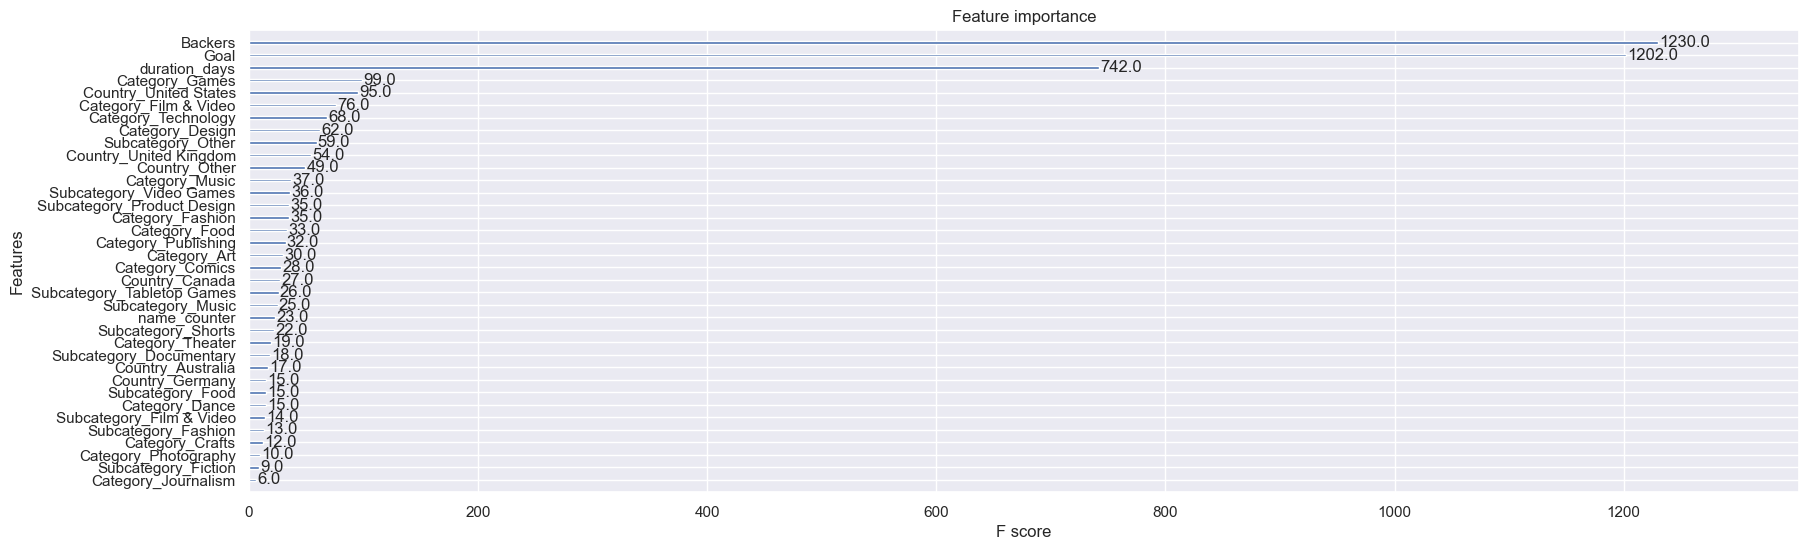

In [15]:
# Train an XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb_model.predict(X_test)

# Validation
validation(y_pred_xgb, y_test)

# Feature Importance
xgb.plot_importance(xgb_model)
plt.show()


## 7. CatBoost
Next, we use CatBoost, a gradient boosting library developed by Yandex that excels in handling categorical features without extensive preprocessing. CatBoost is renowned for its robustness and performance, particularly on datasets with categorical features.

In [16]:
# Train an CatBoost Classifier
cat_model = CatBoostClassifier(silent=True, random_state=42)
cat_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_cat = cat_model.predict(X_test)

# Validation
validation(y_pred_cat, y_test)

Confusion Matrix :
 [[30649  2608]
 [ 1820 31437]]
Accuracy Score : 0.9334275490874102
Report : 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     33257
           1       0.92      0.95      0.93     33257

    accuracy                           0.93     66514
   macro avg       0.93      0.93      0.93     66514
weighted avg       0.93      0.93      0.93     66514



## 8. Model Comparison

We compare the performance of all three models using metrics like accuracy, AUC-ROC, and learning curves. 


AUC: 0.9466048120991188


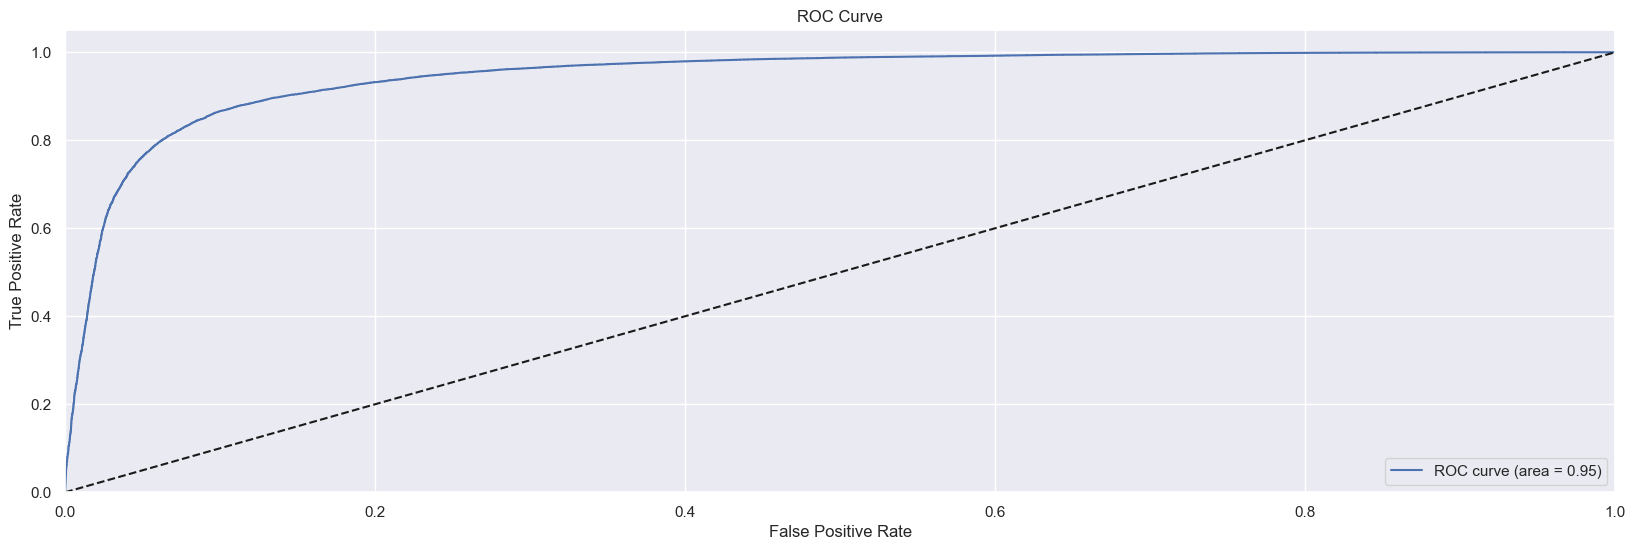

AUC: 0.9770425379148769


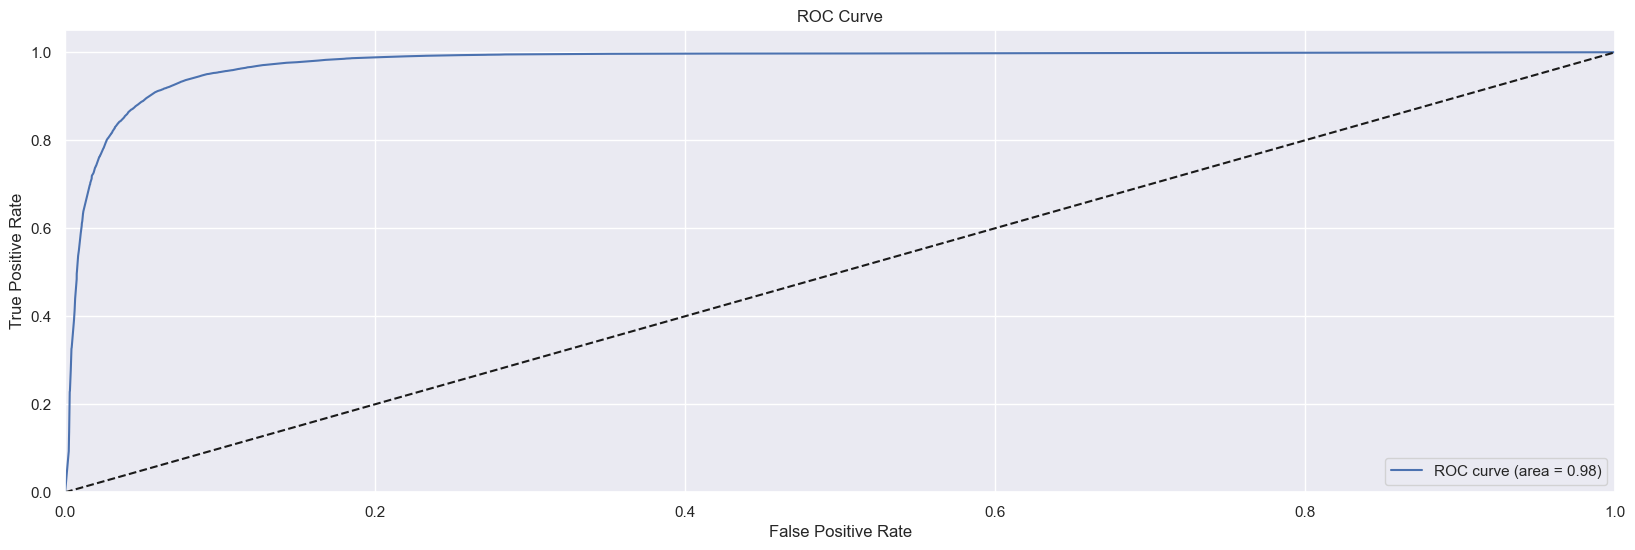

AUC: 0.9825063568528


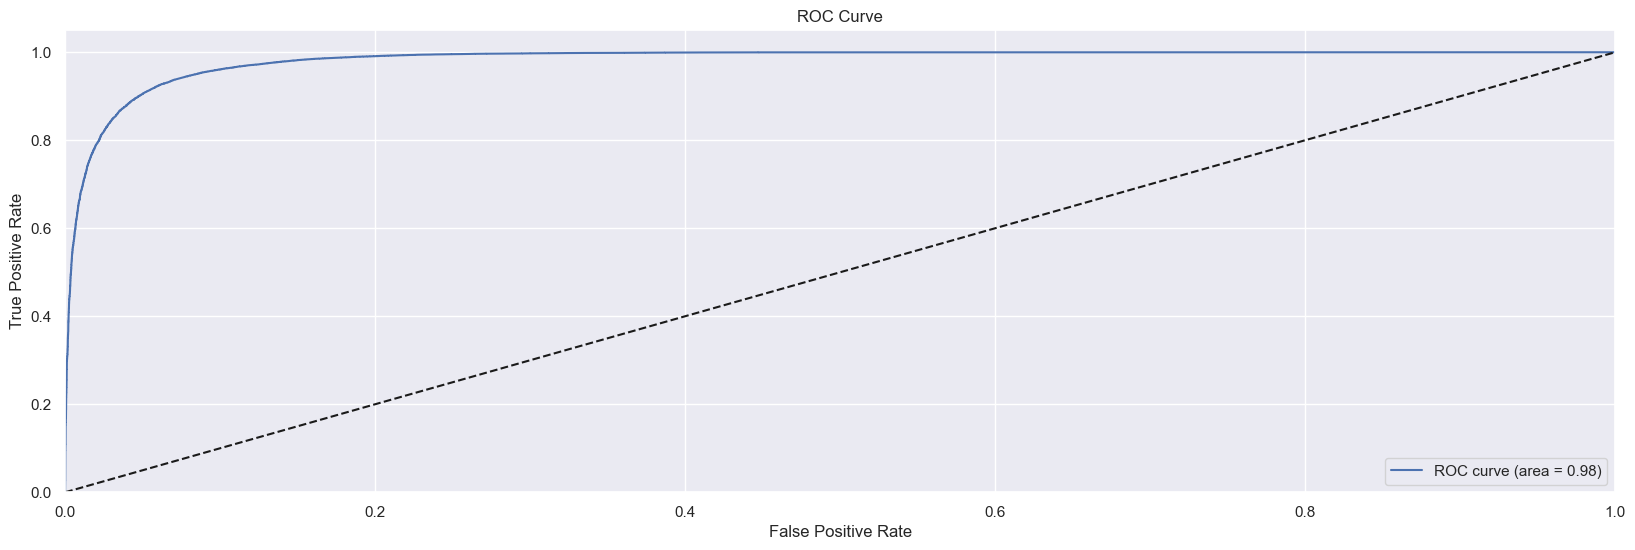

AUC: 0.9829127131838227


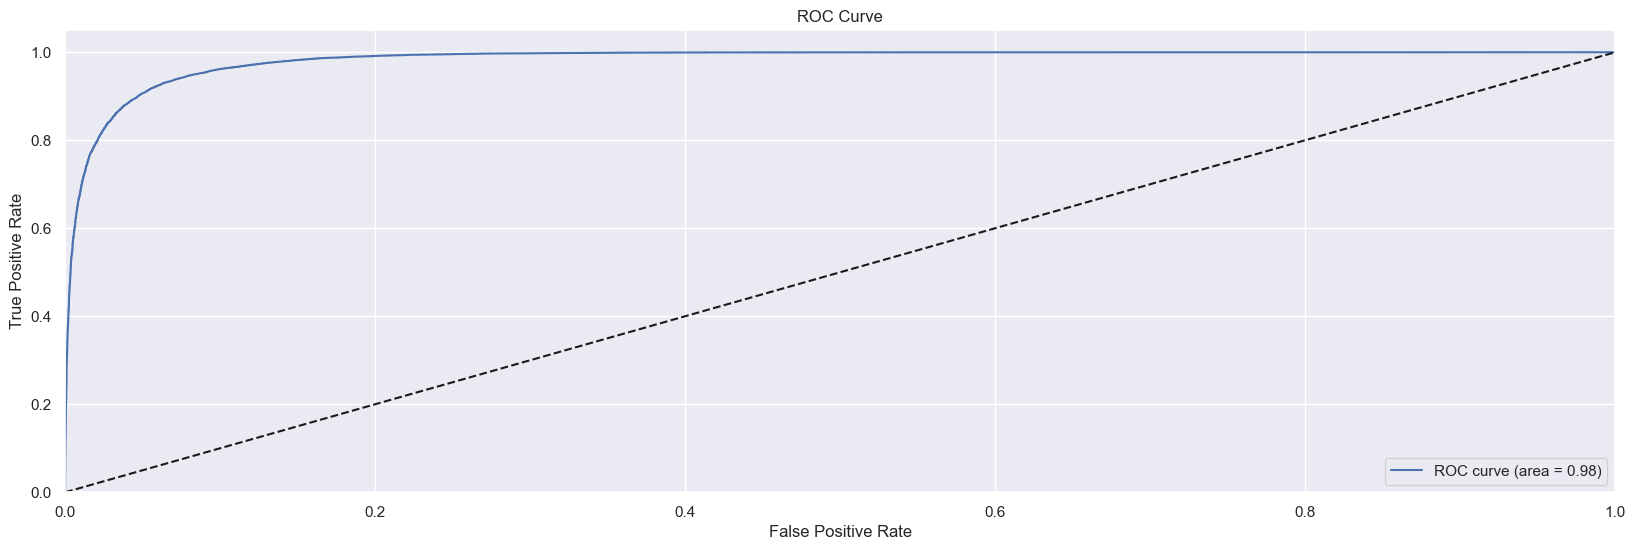

Cross-Validation Accuracy Scores: [0.88012103 0.88333239 0.89240946 0.92537257 0.89908102]
Average Cross-Validation Accuracy: 0.8960632947284385
Cross-Validation Accuracy Scores: [0.92516726 0.92123809 0.92379395 0.93617861 0.93174344]
Average Cross-Validation Accuracy: 0.9276242687893272
Cross-Validation Accuracy Scores: [0.92576862 0.92456447 0.92687602 0.94038827 0.91300671]
Average Cross-Validation Accuracy: 0.9261208179939351
Cross-Validation Accuracy Scores: [0.92507329 0.9250343  0.92683844 0.94136551 0.91214223]
Average Cross-Validation Accuracy: 0.9260907516367226


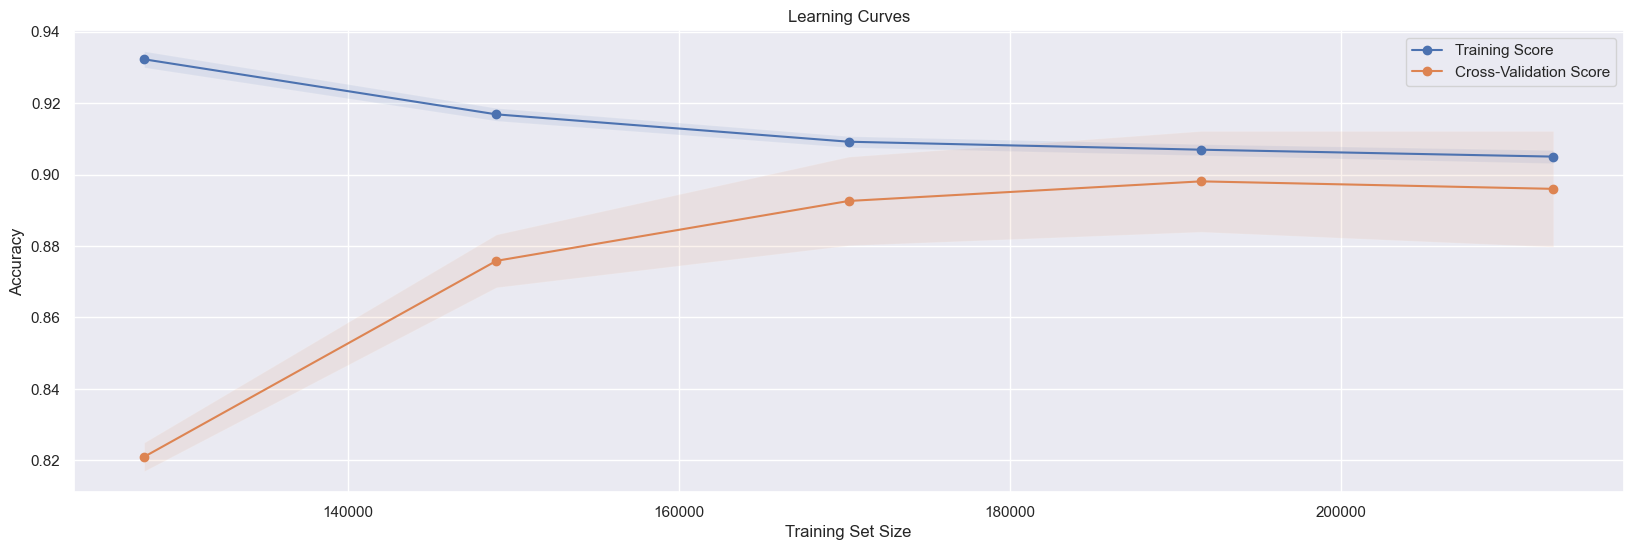

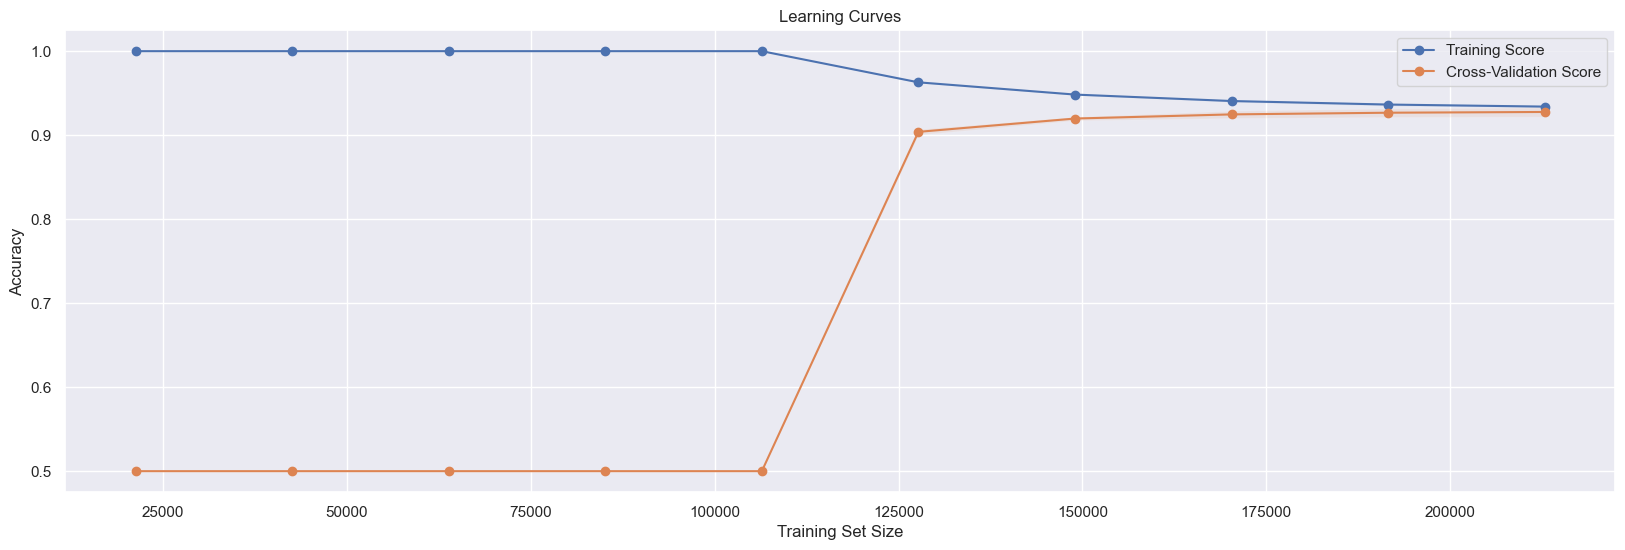

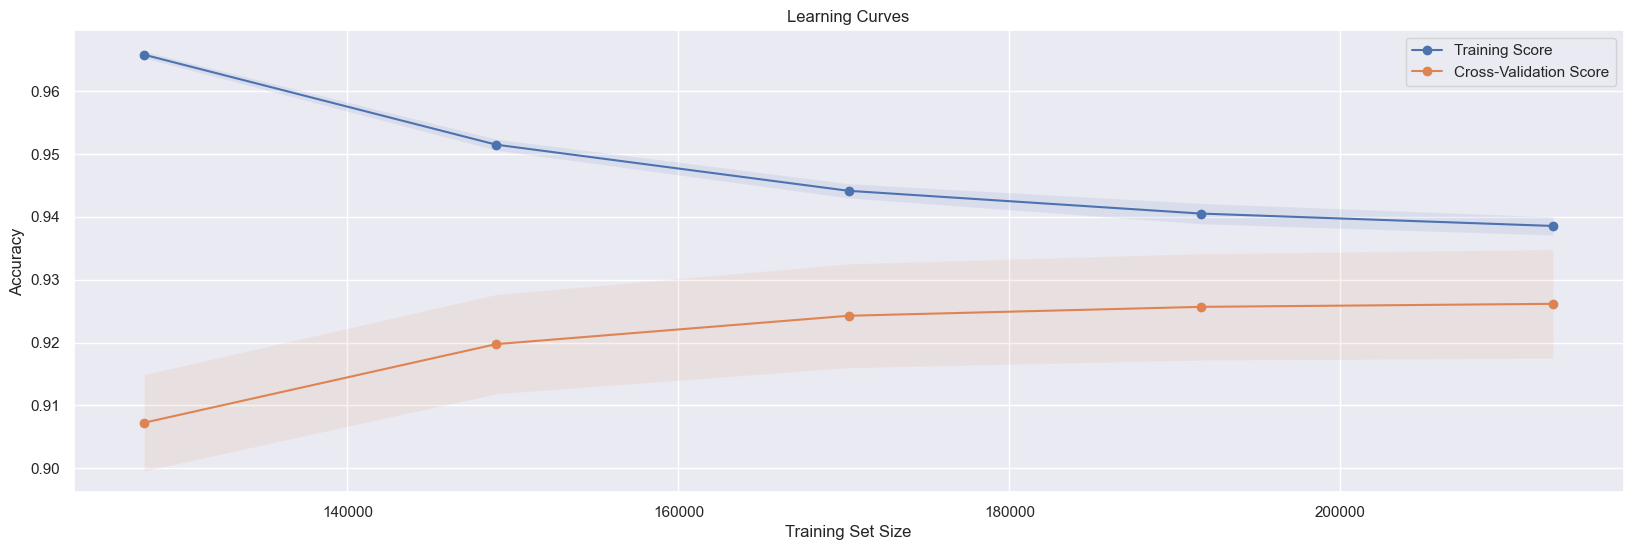

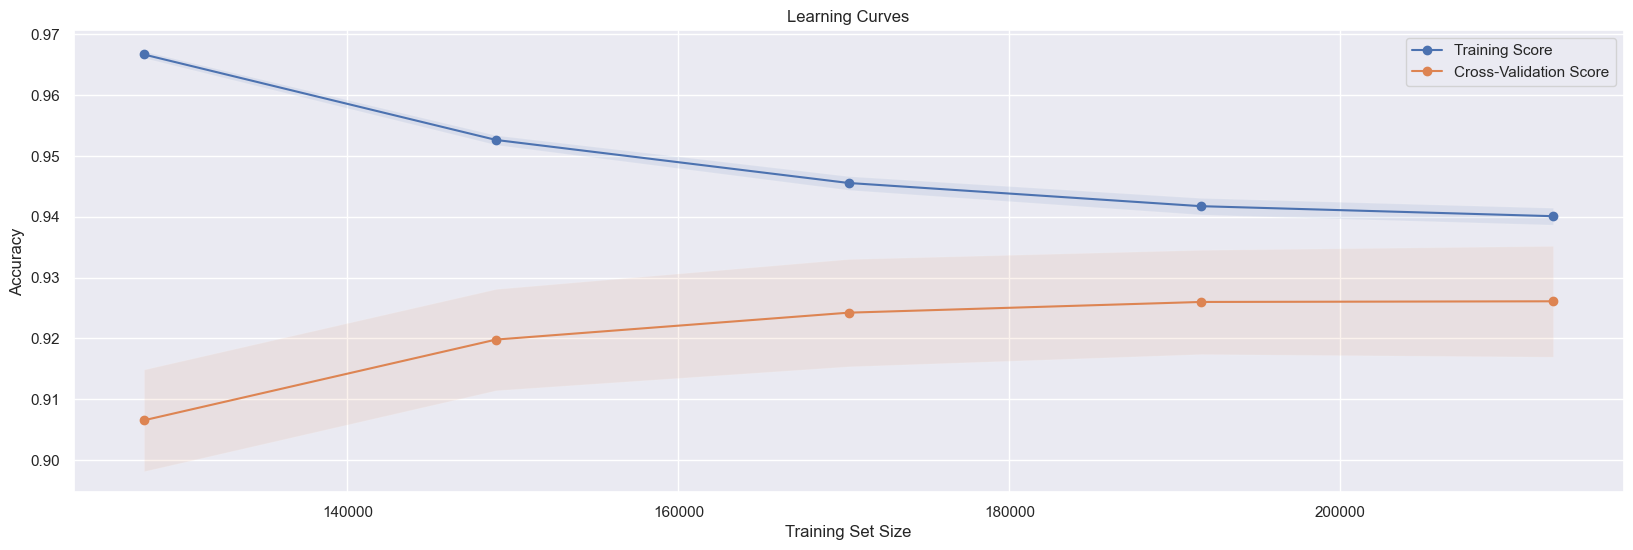

In [17]:
# ROC and AUC comparison
def auc_roc_check (clf, X_test, y_test):
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    print(f'AUC: {auc}')
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

auc_roc_check(logistic_model, X_test_scaled, y_test)
auc_roc_check(tree_model, X_test, y_test)
auc_roc_check(xgb_model, X_test, y_test)
auc_roc_check(cat_model, X_test, y_test)

# Cross-validation and overfitting/underfitting check
def cross_val(clf, X, y, cv_size=5):
    cv_scores = cross_val_score(clf, X, y, cv=cv_size, scoring='accuracy')
    print(f'Cross-Validation Accuracy Scores: {cv_scores}')
    print(f'Average Cross-Validation Accuracy: {cv_scores.mean()}')

cross_val(logistic_model, X, y)
cross_val(tree_model, X, y)
cross_val(xgb_model, X, y)
cross_val(cat_model, X, y)

# Learning curve analysis
def learning_curve_check(clf, X, y, cv_size=5, n_jobs_size=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X, y, cv=cv_size, scoring='accuracy', n_jobs=n_jobs_size, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-Validation Score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves')
    plt.legend(loc="best")
    plt.show()

learning_curve_check(logistic_model, X, y)
learning_curve_check(tree_model, X, y)
learning_curve_check(xgb_model, X, y)
learning_curve_check(cat_model, X, y)


# Conclusion

The notebook offers a structured methodology for analyzing the success of Kickstarter projects. The Logistic Regression model is utilized as a baseline, while more advanced models such as Decision Tree, XGBoost, and CatBoost provide options with the potential for improved performance.

Notably, the Decision Tree model demonstrates from the learning curve plot that a small training set size leads to poor cross-validation scores, with a significant improvement observed when the training set exceeds 125,000 samples.

After evaluating all models, the final selection should be based on achieving an optimal balance between model complexity and predictive accuracy.
